# **Функция предобработки одного изображения для пайплайна**

In [ ]:
%%capture
!pip install autokeras
!pip install deskew

import cv2
import gdown
import tensorflow as tf
import numpy as np
import re

from deskew import determine_skew
from autokeras import CUSTOM_OBJECTS

In [ ]:
# Загрузка модели нахождения поворота изображений на 90°, -90°, 180°
gdown.download(f"https://drive.google.com/uc?id=1ayQNQmPirwYVjTR7E5M4WFrvrclp7J8E", 'rotate_model.h5')
model = tf.keras.models.load_model("rotate_model.h5", custom_objects=CUSTOM_OBJECTS)

Downloading...
From: https://drive.google.com/uc?id=1ayQNQmPirwYVjTR7E5M4WFrvrclp7J8E
To: /content/rotate_model.h5
100%|██████████| 12.5M/12.5M [00:00<00:00, 98.6MB/s]


In [ ]:
def preprocess_for_rot_model(img:np.array) -> np.array:
    """Функция предобработки изображения для модели нахождения поворота."""
    target_size = (224, 224)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    img = img / 255.0

    # Увеличиваем размерности
    img = np.expand_dims(img, axis=2)
    img = np.expand_dims(img, axis=0)

    return img


def process_image(filepath: str, output_folder: str) -> bool:
    """
    Функция для предобработки изображения для дальнейшего использования.
    Открывает файл по пути "filepath".
    Конвертирует его в .png формат.
    Поворачивает изображение на найденный угол через модель нахождения поворота
    и deskew.
    Устанавливает размер по высоте 3508 px, и пропорционально увеличивает ширину.
    Сохраняет изображение в папке output_folder.
    """
    # Открываем изображение
    img = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)

    # Проверка на успешное чтение изображения
    if img is None:
        print(f"Ошибка чтения изображения: {filepath}")
        return False

    # Конвертируем в .png
    _, img = cv2.imencode('.png', img)
    img = cv2.imdecode(img, cv2.IMREAD_UNCHANGED)

    # Нахождение угла поворота на изображении 0°,90°,-90°,180°
    instant_angle_mode = np.argmax(model.predict(preprocess_for_rot_model(img), verbose=False))

    # Находим ширину, высоту и соотношение сторон
    height, width = img.shape[0], img.shape[1]
    aspect_ratio = width / height

    # Нахождения угла поворота -45° - 45°
    deskew_angle = determine_skew(img)

    # Поворот на 90°,-90°,180°
    if instant_angle_mode in [1,2]:         # для 90° и -90°
        height, width = width, height

    instant_angle_cv2 = [cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
    if instant_angle_mode != 0:
        img = cv2.rotate(img, instant_angle_cv2[instant_angle_mode-1])

    # Выравнивание, поворот в пределах -45° - 45°
    rotate_matrix = cv2.getRotationMatrix2D(center=(width/2, height/2), angle=deskew_angle, scale=1)
    img = cv2.warpAffine(src=img, M=rotate_matrix, dsize=(width, height))

    # Определение новой высоты и ширины изображения
    new_height = 3508
    width = int(new_height * aspect_ratio)

    # Изменение размера с сохранением пропорций
    interpolation_mode = cv2.INTER_AREA if height > new_height else cv2.INTER_CUBIC
    img = cv2.resize(img, (width, new_height), interpolation=cv2.INTER_AREA)

    # Преобразовываем в чёрно-белый формат
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Cохранение предобработанного изображения в формате .png
    output_folder = output_folder + re.findall(r'[^/]+\.', filepath)[0] + '.png'
    cv2.imwrite(output_folder, img)

    return True

# *Тест функции*

In [ ]:
import matplotlib.pyplot as plt

import random
import os
import cv2

In [ ]:
from google.colab import drive # Подключаем google диск
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Путь к файлам на google диске
directory = '/content/drive/MyDrive/Colab/Базы/Стажировка 2023/Распознавание информации на платежных поручениях/Scans/'

fileslist = os.listdir(directory)   # Список всех файлов

In [ ]:
def print_img(img_path, figsize=(12,8), title='File'):
    # Открываем файл
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Отображение изображения с помощью Matplotlib
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.title(title)  # Установка заголовка из названия файла
    plt.axis('off')  # Убрать оси координат
    plt.show()

def print_imgs(img_path1, img_path2, title1='Оригинал', title2='Предобработка', figsize=(12, 8)):
    # Открываем файлы
    img1 = cv2.imread(img_path1, cv2.IMREAD_UNCHANGED)
    img1_shape = '\n' + str(img1.shape)
    img1_size = os.path.getsize(img_path1) / (1024 * 1024)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

    img2 = cv2.imread(img_path2, cv2.IMREAD_UNCHANGED)
    img2_shape = '\n' + str(img2.shape)
    img2_size = os.path.getsize(img_path2) / (1024 * 1024)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB)

    size_difference = img2_size / img1_size - 1
    size_difference =  f' ({size_difference:+.3%})'

    img1_size = '\n' + str(round(img1_size, 3)) + 'МБ'
    img2_size = '\n' + str(round(img2_size, 3)) + 'МБ'

    # Создаем subplot для двух изображений
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Отображаем первое изображение
    ax1.imshow(img1)
    ax1.set_title(title1 + img1_shape + img1_size)  # Устанавливаем подпись для первого изображения
    ax1.axis('off')  # Убираем оси для первого изображения

    # Отображаем второе изображение
    ax2.imshow(img2)
    ax2.set_title(title2 + img2_shape + img2_size + size_difference)  # Устанавливаем подпись для второго изображения
    ax2.axis('off')  # Убираем оси для второго изображения

    # Установка серого фона для графика
    fig.patch.set_facecolor('lightgrey')

    plt.show()

# Пример использования функции:
# print_imgs('путь_к_первому_изображению.jpg', 'путь_к_второму_изображению.jpg', title1='Image 1', title2='Image 2')

## Проверка случайного файла

2067 - /content/drive/MyDrive/Colab/Базы/Стажировка 2023/Распознавание информации на платежных поручениях/Scans/785895d5-4f28-4283-96f2-c128bf0c0478.jpg


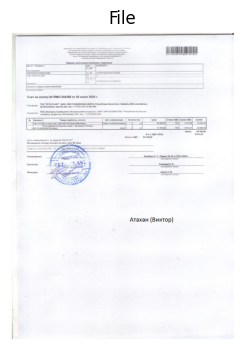

In [ ]:
# Берём случайный файл
filepath = random.choice(fileslist)
print(fileslist.index(filepath), '-', directory + filepath)
filepath = directory + filepath
print_img(filepath, (8,4))

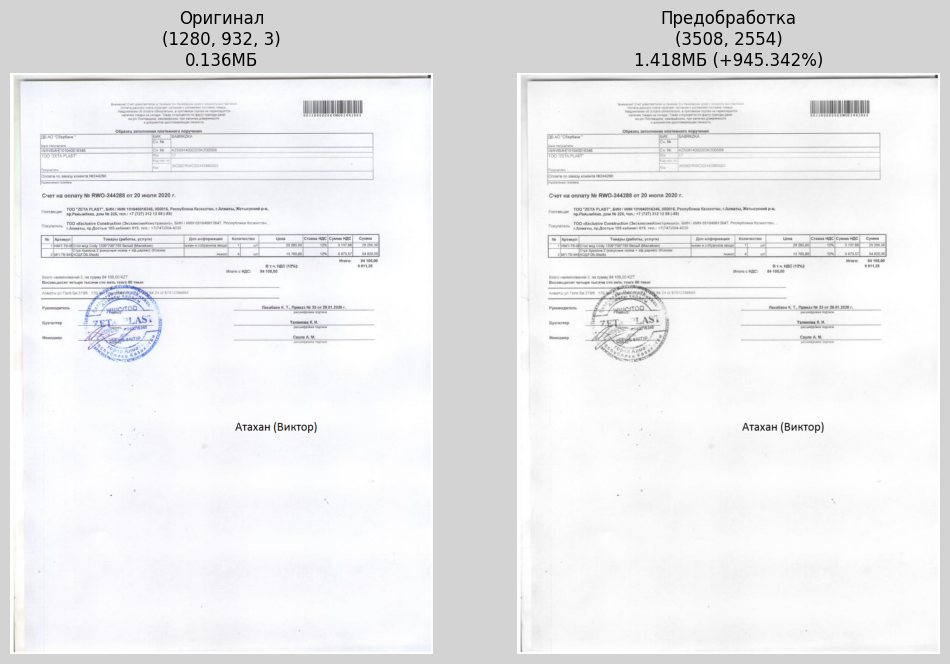

In [ ]:
output_folder = '/content/'
process_image(filepath, output_folder)

print_imgs(filepath, output_folder + re.findall(r'[^/]+\.', filepath)[0] + '.png')

## Проверка определённого файла

11 - /content/drive/MyDrive/Colab/Базы/Стажировка 2023/Распознавание информации на платежных поручениях/Scans/invoice_86_19.03.2019_170240000298_550706300319.jpg


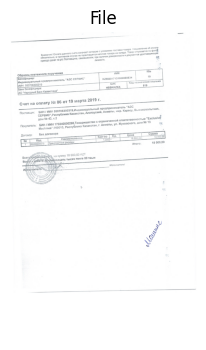

In [ ]:
# Берём конкретный файл
file_index = 11 # 108 148
filepath = directory + fileslist[file_index]
print(file_index, '-', filepath)
print_img(filepath, (8,4))

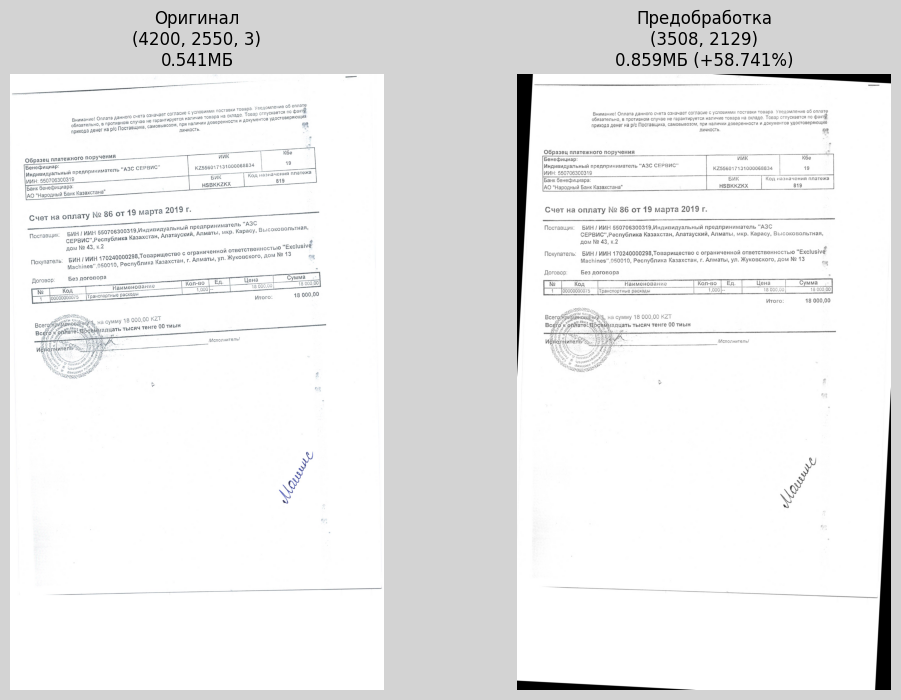

In [ ]:
output_folder = '/content/'
process_image(filepath, output_folder)

print_imgs(filepath, output_folder + re.findall(r'[^/]+\.', filepath)[0] + '.png')

In [ ]:
# Проверка файлов для выбора изображения
for i in range(100,120):
    file_index = i
    filepath = directory + fileslist[file_index]
    print(i, '-', filepath)
    print_img(filepath)